# Learn how to perform regression

We're going to train a neural network that knows how to perform inference in robust linear regression models.
The network will have as input: 

* $x$, a vector of input values, and 
* $y$, a vector of output values.

It will learn how to perform posterior inference for the parameter vector $w$, in a linear regression model.

In [3]:
import numpy as np
import torch
from torch.autograd import Variable
import sys, inspect
sys.path.insert(0, '..')

%matplotlib inline
import pymc
import matplotlib.pyplot as plt

from learn_smc_proposals import cde
from learn_smc_proposals.utils import systematic_resample

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('ticks')

First step: let's define linear regression as a PyMC model. This model has:

* an intercept term, a linear term, and a quadratic term
* Laplace distribution (double exponential) priors on the weights
* T-distributed (heavy-tailed) likelihoods


In [4]:
num_points = 10 # number of points in the synthetic dataset we train on

def robust_regression(x, t, sigma_0=np.array([10.0, 1.0, .1]), epsilon=1.0):
    """ X: input (NxD matrix)
        t: output (N vector)
        sigma_0: prior std hyperparameter for weights
        epsilon: std hyperparameter for output noise """
    
    if x is not None:
        N, D = x.shape
        assert D == 1
    else:
        N = num_points
        D = 1
    
    # assume our input variable is bounded by some constant
    const = 10.0
    x = pymc.Uniform('x', lower=-const, upper=const, value=x, size=(N, D), observed=(x is not None))
    
    # create design matrix (add intercept)
    @pymc.deterministic(plot=False)
    def X(x=x, N=N):
        return np.hstack((np.ones((N,1)), x, x**2))

    w = pymc.Laplace('w', mu=np.zeros((D+2,)), tau=sigma_0**(-1.0))
    
    @pymc.deterministic(plot=False, trace=False)
    def mu(X=X, w=w):
        return np.dot(X, w)
    
    y = pymc.NoncentralT('y', mu=mu, lam=epsilon**(-2.0), nu=4, value=t, observed=(t is not None))

    return locals()

## Instantiate the generative model

We'll define `M_train`, a PyMC model which doesn't have any data attached.

We can use `M_train.draw_from_prior()` to construct synthetic datasets to use for training.

In [5]:
M_train = pymc.Model(robust_regression(None, None))

def get_observed(model):
    return np.atleast_2d(np.concatenate((model.x.value.ravel(), model.y.value.ravel())))

def get_latent(model):
    return np.atleast_2d(model.w.value)

def generate_synthetic(model, size=100):
    observed, latent = get_observed(model), get_latent(model)
    for i in range(int(size)-1):
        model.draw_from_prior()
        observed = np.vstack((observed, get_observed(model)))
        latent = np.vstack((latent, get_latent(model)))
    return observed, latent

gen_data = lambda num_samples: generate_synthetic(M_train, num_samples)
example_minibatch = gen_data(100)

## Define a network which will invert this model

Each of the 3 dimensions of the latent space will be modeled by a mixture of Gaussians.

In [6]:
observed_dim = num_points*2
latent_dim = 3
hidden_units = 300
hidden_layers = 2
mixture_components = 3
dist_est = cde.ConditionalRealValueMADE(observed_dim, latent_dim, hidden_units, hidden_layers, mixture_components)
if torch.cuda.is_available():
    dist_est.cuda()

dist_est

ConditionalRealValueMADE(
  (relu): ReLU()
  (softplus): Softplus(beta=1, threshold=20)
  (layers): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=300)
    (1): MaskedLinear(in_features=300, out_features=300)
  )
  (skip_alpha): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=3)
    (1): MaskedLinear(in_features=23, out_features=3)
    (2): MaskedLinear(in_features=23, out_features=3)
  )
  (skip_mu): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=3)
    (1): MaskedLinear(in_features=23, out_features=3)
    (2): MaskedLinear(in_features=23, out_features=3)
  )
  (skip_sigma): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=3)
    (1): MaskedLinear(in_features=23, out_features=3)
    (2): MaskedLinear(in_features=23, out_features=3)
  )
  (alpha): ModuleList(
    (0): MaskedLinear(in_features=300, out_features=3)
    (1): MaskedLinear(in_features=300, out_features=3)
    (2): MaskedLinear(in_features=300, out_features=3)
  )


### We can use our network to sample and to compute logpdfs.

The primary interface is through `.sample(parents)`, and `.logpdf(parents, latent)`.

Both of these expect pytorch tensors as inputs.

In [7]:
example_parents = Variable(torch.FloatTensor(example_minibatch[0][:5]))
example_latents = Variable(torch.FloatTensor(example_minibatch[1][:5]))
if torch.cuda.is_available():
    example_parents = example_parents.cuda()
    example_latents = example_latents.cuda()

print("Sampled from p(latent|parents):\n\n", dist_est.sample(example_parents))
print("Evaluate log p(latent|parents):\n\n", dist_est.logpdf(example_parents, example_latents))

Sampled from p(latent|parents):

 Variable containing:
-1.4641  0.0825 -0.5918
-0.6610  0.2326 -0.8845
-0.0814 -0.7205 -0.0377
 0.3079  0.0040 -1.3146
-1.5825 -0.3064  0.4987
[torch.cuda.FloatTensor of size 5x3 (GPU 0)]

Evaluate log p(latent|parents):

 Variable containing:
-283.8195
-144.7566
 -17.4010
  -8.4763
 -49.1602
[torch.cuda.FloatTensor of size 5x1 (GPU 0)]



## Optimize network parameters

The `training_epoch` code samples a synthetic dataset, and performs minibatch updates on it for a while. Optionally, it can decide when to stop by examining synthetic validation data.

In [8]:
def _iterate_minibatches(inputs, outputs, batchsize):
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield Variable(torch.FloatTensor(inputs[excerpt])), Variable(torch.FloatTensor(outputs[excerpt]))

def training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, max_local_iters=10, misstep_tolerance=0, verbose=False):
    """ Training function for fitting density estimator to simulator output """
    # Train
    synthetic_ins, synthetic_outs = gen_data(dataset_size)
    validation_size = dataset_size/10
    validation_ins, validation_outs = [Variable(torch.FloatTensor(t)) for t in gen_data(validation_size)]
    missteps = 0
    num_batches = float(dataset_size)/batch_size
    
    USE_GPU = dist_est.parameters().__next__().is_cuda
    if USE_GPU:
        validation_ins = validation_ins.cuda()
        validation_outs = validation_outs.cuda()
    
    validation_err = -torch.mean(dist_est.logpdf(validation_ins, validation_outs)).data[0]
    for local_iter in range(max_local_iters):
        
        train_err = 0 
        for inputs, outputs in _iterate_minibatches(synthetic_ins, synthetic_outs, batch_size):
            optimizer.zero_grad()
            if USE_GPU:
                loss = -torch.mean(dist_est.logpdf(inputs.cuda(), outputs.cuda()))
            else:
                loss = -torch.mean(dist_est.logpdf(inputs, outputs))
            loss.backward()
            optimizer.step()
            train_err += loss.data[0]/num_batches
            
        next_validation_err = -torch.mean(dist_est.logpdf(validation_ins, validation_outs)).data[0]
        if next_validation_err > validation_err:
            missteps += 1
        validation_err = next_validation_err
        if missteps > misstep_tolerance:
            break

    if verbose:
        print(train_err, validation_err, "(", local_iter+1, ")")
        
    return train_err, validation_err, local_iter+1

In [9]:
optimizer = torch.optim.Adam(dist_est.parameters())
trace_train = []
trace_validation = []
trace_local_iters = []

In [21]:
num_iterations = 1500
dataset_size = 2500
batch_size = 250

for i in range(num_iterations):
    verbose = (i+1) % 25 == 0
    if verbose:
        print("["+str(1+len(trace_train))+"]")
    t,v,l = training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, verbose=verbose)
    trace_train.append(t)
    trace_validation.append(v)
    trace_local_iters.append(l)

[525]
-0.34280051589012145 -0.008739883080124855 ( 2 )
[550]
-0.5971786737442016 -0.37218210101127625 ( 3 )
[575]
-0.35376400947570796 -0.4004380404949188 ( 2 )
[600]
-0.535977977514267 -0.127024307847023 ( 2 )
[625]
-0.16880121380090715 -0.01767650991678238 ( 1 )
[650]
-0.17563482671976088 0.008182460442185402 ( 1 )
[675]
-0.7545483112335206 -0.3355959355831146 ( 3 )
[700]
-0.825270825624466 -0.20250503718852997 ( 3 )
[725]
-0.7158690929412841 0.8449916839599609 ( 3 )
[750]
-0.8833897590637206 -0.31922128796577454 ( 3 )
[775]
-0.4521592050790787 -0.4102376103401184 ( 1 )
[800]
-0.33077216222882266 -0.21134145557880402 ( 1 )
[825]
-0.8349732279777528 -0.43735963106155396 ( 3 )
[850]
-0.6467211037874222 -0.4827100932598114 ( 3 )
[875]
-0.7705252438783645 -0.4389556646347046 ( 3 )
[900]
-0.7350098311901092 -0.6029106974601746 ( 2 )
[925]
-0.9012903928756713 -0.3474562168121338 ( 3 )
[950]
-0.6351594015955926 -0.5941306352615356 ( 4 )
[975]
-0.6047127813100814 -0.25032132863998413 ( 2 )
[

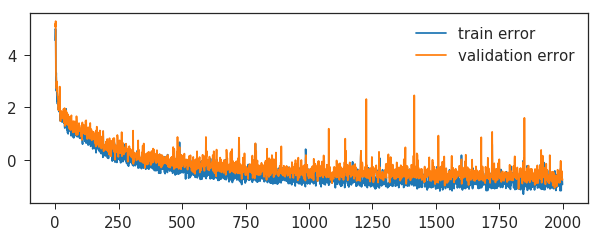

In [22]:
plt.figure(figsize=(10,3.5))
plt.plot(np.array(trace_train))
plt.plot(np.array(trace_validation))
plt.legend(['train error', 'validation error']);

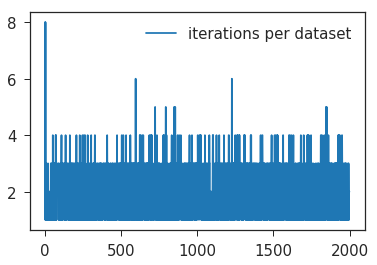

In [23]:
plt.plot(np.array(trace_local_iters))
plt.legend(['iterations per dataset'])

## Define plotting and testing functions

We'll use PyMC's default Metropolis-Hastings as a benchmark, and compare to sampling directly from the learned model, and importance sampling.

In [24]:
def gen_example_pair(model):
    model.draw_from_prior()
    data_x = model.X.value
    data_y = model.y.value
    true_w = model.w.value
    return data_x, data_y, true_w

def estimate_MCMC(data_x, data_y, ns, iters=10000, burn=0.5):
    """ MCMC estimate of weight distribution """
    mcmc_est = pymc.MCMC(robust_regression(data_x[:,1:2], data_y))
    mcmc_est.sample(iters, burn=burn*iters, thin=np.ceil(burn*iters/ns))
    trace_w = mcmc_est.trace('w').gettrace()[:ns]
    return trace_w

def estimate_NN(network, data_x, data_y, ns):
    """ NN proposal density for weights """
    nn_input = Variable(torch.FloatTensor(np.concatenate((data_x[:,1], data_y[:]))))
    print(nn_input.size())
    nn_input = nn_input.unsqueeze(0).repeat(ns,1)
    if network.parameters().__next__().is_cuda:
        nn_input = nn_input.cuda()
    values, log_q = network.propose(nn_input)
    return values.cpu().data.numpy(), log_q.squeeze().cpu().data.numpy()

def sample_prior_proposals(model, ns):
    samples = []
    for n in range(ns):
        model.draw_from_prior()
        samples.append(model.w.value)
    return np.array(samples)

def compare_and_plot(ns=100, alpha=0.05, data_x=None, data_y=None, true_w=None):
    model = pymc.Model(robust_regression(None, None))
    prior_proposals = sample_prior_proposals(model, ns*10)
    if data_x is None:
        data_x, data_y, true_w = gen_example_pair(model)
    mcmc_trace = estimate_MCMC(data_x, data_y, ns)
    nn_proposals, logq = estimate_NN(dist_est, data_x, data_y, ns*10)
    mcmc_mean = mcmc_trace.mean(0)
    nn_mean = nn_proposals.mean(0)
    print()
    print("True (generating) w:", true_w)
    print("MCMC weight mean:", mcmc_mean)
    print("NN weight proposal mean:", nn_mean)
    
    domain = np.linspace(min(data_x[:,1])-2, max(data_x[:,1])+2, 50)
    plt.figure(figsize=(14,3))
    plt.subplot(141)

    plt.plot(domain, mcmc_mean[0] + mcmc_mean[1]*domain + mcmc_mean[2]*domain**2, "b--")
    for i in range(ns):
        plt.plot(domain, mcmc_trace[i,0] + mcmc_trace[i,1]*domain + mcmc_trace[i,2]*domain**2, "b-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.xlim(np.min(domain),np.max(domain))
    limy = plt.ylim()
    plt.legend(["MH posterior"])

    ax = plt.subplot(143)
    plt.plot(domain, nn_mean[0] + nn_mean[1]*domain + nn_mean[2]*domain**2, "r--")
    for i in range(ns):
        plt.plot(domain, nn_proposals[i,0] + nn_proposals[i,1]*domain  + nn_proposals[i,2]*domain**2, "r-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["NN proposal"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));
    ax.yaxis.set_ticklabels([])
    
    ax = plt.subplot(142)
    prior_samples_mean = prior_proposals.mean(0)
    prior_proposals = prior_proposals[::10]
    plt.plot(domain, prior_samples_mean[0] + prior_samples_mean[1]*domain + prior_samples_mean[2]*domain**2, "c--")
    for i in range(ns):
        plt.plot(domain, prior_proposals[i,0] + prior_proposals[i,1]*domain  + prior_proposals[i,2]*domain**2, "c-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["Prior"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));    
    ax.yaxis.set_ticklabels([])

    # compute NN-IS estimate
    logp = []
    nn_test_model = pymc.Model(robust_regression(data_x[:,1:2], data_y))
    for nnp in nn_proposals:
        nn_test_model.w.value = nnp
        try:
            next_logp = nn_test_model.logp
        except:
            next_logp = -np.Inf
        logp.append(next_logp)
    logp = np.array(logp)
    w = np.exp(logp - logq) / np.sum(np.exp(logp - logq))
    nnis_mean = np.sum(w*nn_proposals.T,1)
    print("NN-IS estimated mean:", nnis_mean)
    print("NN-IS ESS:", 1.0/np.sum(w**2), w.shape[0])
    
    ax = plt.subplot(144)
    plt.plot(domain, nnis_mean[0] + nnis_mean[1]*domain + nnis_mean[2]*domain**2, "g--")
    
    nn_resampled = nn_proposals[systematic_resample(np.log(w))][::10]
    for i in range(ns):
        plt.plot(domain, nn_resampled[i,0] + nn_resampled[i,1]*domain  + nn_resampled[i,2]*domain**2, "g-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["NN-IS posterior"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));
    ax.yaxis.set_ticklabels([])
    
    plt.tight_layout()

 [-----------------100%-----------------] 10000 of 10000 complete in 0.8 sectorch.Size([20])

True (generating) w: [ 11.36587311   0.91800668  -0.1270442 ]
MCMC weight mean: [ 10.00177798   0.87033328  -0.120826  ]
NN weight proposal mean: [ 9.3512125   0.84122223 -0.08389995]
NN-IS estimated mean: [ 10.19440003   0.90691714  -0.12125428]
NN-IS ESS: 44.6456098144 1000


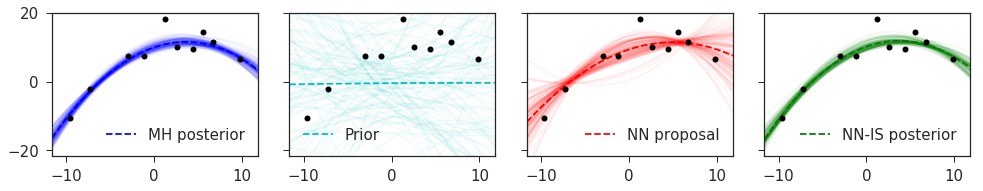

In [25]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [-1.0608203  -1.41537805  0.01950693]
MCMC weight mean: [-0.01874509 -1.48017616 -0.00791823]
NN weight proposal mean: [ 0.21511522 -1.5229249  -0.01736375]
NN-IS estimated mean: [-0.28770172 -1.48840704  0.00292746]
NN-IS ESS: 86.0719475813 1000


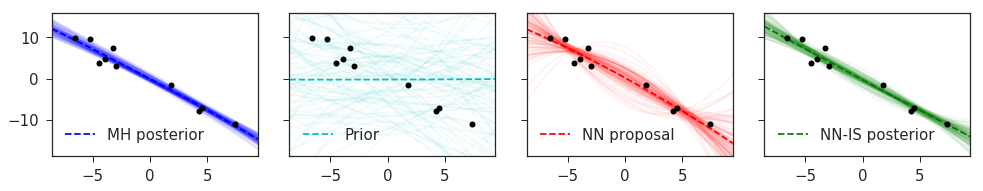

In [26]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [ -9.91134741e+00   1.00150473e-03   7.17036951e-02]
MCMC weight mean: [-8.7870082   0.0162199   0.03270769]
NN weight proposal mean: [ -8.12979031e+00  -5.07991808e-03   1.55758085e-02]
NN-IS estimated mean: [ -9.17142888e+00   4.52828222e-03   4.56212775e-02]
NN-IS ESS: 209.084252731 1000


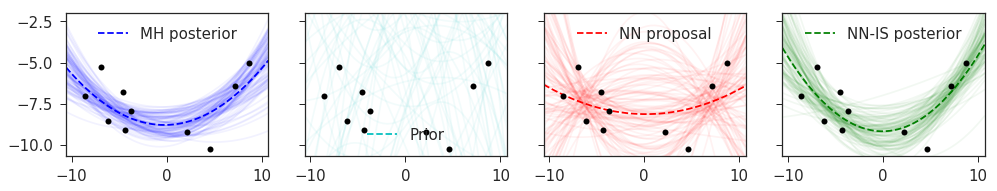

In [27]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [-25.63639095  -0.36018034   0.05648483]
MCMC weight mean: [-24.35930083  -0.3319831    0.02623371]
NN weight proposal mean: [ -2.29587841e+01  -4.29140329e-01  -1.34997061e-02]
NN-IS estimated mean: [-24.43244878  -0.31705284   0.02917752]
NN-IS ESS: 125.66312697 1000


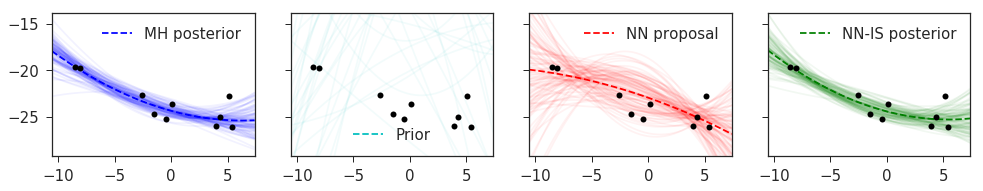

In [28]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.8 sectorch.Size([20])

True (generating) w: [ 29.47129137  -6.2528711   -0.1955427 ]
MCMC weight mean: [ 38.17077469  -0.18730459   0.42337724]
NN weight proposal mean: [ 23.25833702  -3.49468946   0.04860025]
NN-IS estimated mean: [ 30.22661695  -5.39201979  -0.12232772]
NN-IS ESS: 2.21581870421 1000


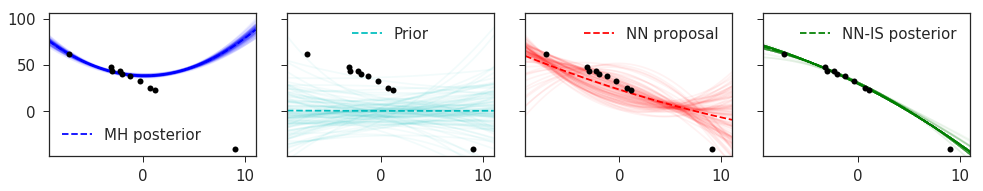

In [19]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sectorch.Size([20])

True (generating) w: [ 3.75570038 -0.9811518  -0.09542925]
MCMC weight mean: [ 3.48964185 -0.98680079 -0.1010007 ]
NN weight proposal mean: [-2.93964887 -0.96240044  0.03566341]
NN-IS estimated mean: [ 3.49819339 -0.97225093 -0.10048267]
NN-IS ESS: 45.9338058912 1000


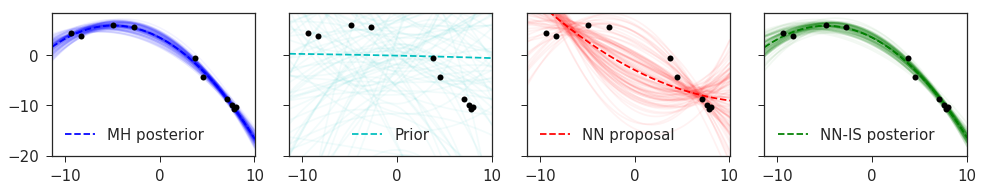

In [20]:
compare_and_plot();